In [1]:
import sys
import os

In [2]:
import pandas as pd
import numpy as np

In [7]:
import os
os.environ['BUILD_PROJECT_PATH'] = r'C:\Users\L110006\OneDrive - Eli Lilly and Company\personal files\build project'
build_project_path = os.environ.get('BUILD_PROJECT_PATH')
test_data_path = os.path.join(build_project_path, 'fine_tuning', 'data', 'datasets', 'test_ds.csv')
#fine_tuned_model_path = os.path.join(build_project_path,'fine-tuning-build-project', 'streamlit_app', 'data', 'fine_tuned_model')
fine_tuned_model_path = os.path.join(build_project_path,'fine-tuning-build-project', 'streamlit_app', 'data','checkpoint-29')

In [8]:
test_df = pd.read_csv(test_data_path)

In [9]:
from sentence_transformers import SentenceTransformer
import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

In [13]:
from sentence_transformers import SentenceTransformer

base_model_name = "all-MiniLM-L6-v2"  # or whichever you used
model = SentenceTransformer(base_model_name)


In [14]:
base_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
model_save_path = os.path.join(build_project_path, "fine_tuned_model")
model.save(model_save_path)
fine_tuned_model = SentenceTransformer(model_save_path, device=device)
#fine_tuned_model = SentenceTransformer(fine_tuned_model_path, device=device)

In [15]:
from tqdm.autonotebook import trange

jittered_titles = test_df['jittered_title'].to_list()

base_model_embeddings = []
fine_tuned_embeddings = []
for i in trange(0, len(jittered_titles), 100):
    chunk = jittered_titles[i:i+100]
    base_model_embeddings.append(base_model.encode(chunk, normalize_embeddings=True, convert_to_numpy=True, device=device))
    fine_tuned_embeddings.append(fine_tuned_model.encode(chunk, normalize_embeddings=True, convert_to_numpy=True, device=device))

base_model_embeddings = np.concatenate(base_model_embeddings)
fine_tuned_embeddings = np.concatenate(fine_tuned_embeddings)

  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\L110006\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [16]:
from sklearn.manifold import TSNE
# --- Dimensionality Reduction using t-SNE ---
tsne = TSNE(n_components=2, random_state=101)

base_model_embeddings_2d = tsne.fit_transform(base_model_embeddings)
fine_tuned_embeddings_2d = tsne.fit_transform(fine_tuned_embeddings)

In [19]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 14.2 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 15.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 14.3 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 16.9 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


C:\Users\L110006\AppData\Local\Temp\ipykernel_27560\959577880.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))
C:\Users\L110006\AppData\Local\Temp\ipykernel_27560\959577880.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


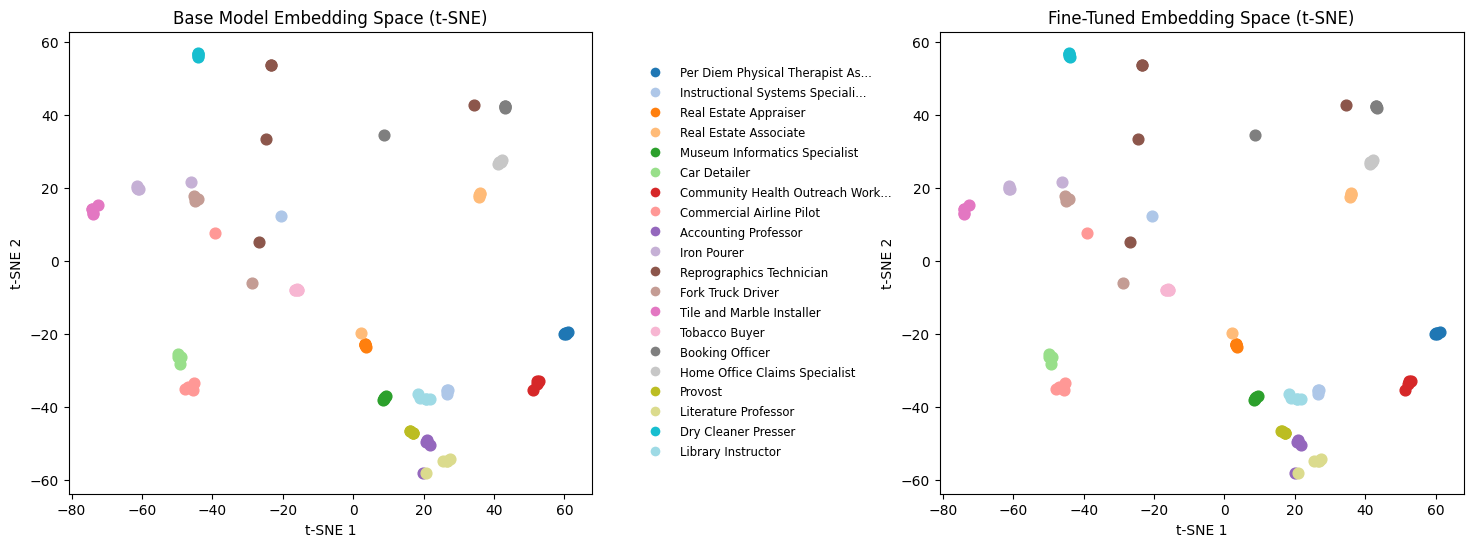

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# --- Data Subset and Embedding Extraction ---
subset_size = 20
random_seed_title_subset = np.random.choice(test_df['seed_title'].unique(), subset_size, replace=False)
seed_title_mask = test_df['seed_title'].isin(random_seed_title_subset)

test_df_subset = test_df[seed_title_mask]

base_model_embeddings_subset_2d = base_model_embeddings_2d[seed_title_mask, :]
fine_tuned_embeddings_subset_2d = fine_tuned_embeddings_2d[seed_title_mask, :]

# --- Prepare Color Mapping using 'tab20' for up to 20 classes ---
unique_labels = test_df_subset['seed_title'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

# Truncate long label names for the legend.
max_label_len = 30
short_labels = {
    label: (label if len(label) <= max_label_len else label[:max_label_len] + '...')
    # label: label
    for label in unique_labels
}

# --- Create Figure with GridSpec Layout ---
# Three columns: left for base model plot, middle for legend, right for fine-tuned plot.
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.35, 1], wspace=0.2)

ax_left = fig.add_subplot(gs[0])
ax_right = fig.add_subplot(gs[2])
ax_legend = fig.add_subplot(gs[1])

# --- Plot Base Model Embedding Space ---
for label in unique_labels:
    idx = test_df_subset['seed_title'] == label
    ax_left.scatter(base_model_embeddings_subset_2d[idx, 0], base_model_embeddings_subset_2d[idx, 1],
                    color=color_map[label], s=60)
ax_left.set_title("Base Model Embedding Space (t-SNE)")
ax_left.set_xlabel("t-SNE 1")
ax_left.set_ylabel("t-SNE 2")

# --- Plot Fine-Tuned Embedding Space ---
for label in unique_labels:
    idx = test_df_subset['seed_title'] == label
    ax_right.scatter(fine_tuned_embeddings_subset_2d[idx, 0], fine_tuned_embeddings_subset_2d[idx, 1],
                     color=color_map[label], s=60)
ax_right.set_title("Fine-Tuned Embedding Space (t-SNE)")
ax_right.set_xlabel("t-SNE 1")
ax_right.set_ylabel("t-SNE 2")

# --- Create a Vertical Legend in the Middle Column ---
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[label], markersize=8,
               label=short_labels[label])
    for label in unique_labels
]
ax_legend.axis('off')  # Hide the axis for the legend.
legend = ax_legend.legend(handles=handles, loc='center', frameon=False, ncol=1)
plt.setp(legend.get_texts(), fontsize='small')  # Adjust font size if needed

plt.tight_layout()
plt.show()

In [17]:
pip install peft


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from peft import get_peft_model, LoraConfig, TaskType
from tqdm.autonotebook import trange

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
build_project_path = r"C:\Users\L110006\OneDrive - Eli Lilly and Company\personal files\build project"
data_path = os.path.join(build_project_path, "fine_tuning", "data", "datasets")
train_data_path = os.path.join(data_path, "train_ds.csv")
test_data_path = os.path.join(data_path, "test_ds.csv")
model_save_path = os.path.join(build_project_path, "lora_fine_tuned_model")

# -------------------------------------------------------------------
# Device setup
# -------------------------------------------------------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)

# -------------------------------------------------------------------
# Load base SentenceTransformer
# -------------------------------------------------------------------
base_model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(base_model_name, device=device)

# -------------------------------------------------------------------
# Apply LoRA adapters with PEFT
# -------------------------------------------------------------------
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # embedding task
    r=8,  # rank
    lora_alpha=32,
    lora_dropout=0.1
)

# Apply LoRA to the internal transformer
model[0].auto_model = get_peft_model(model[0].auto_model, lora_config)

# -------------------------------------------------------------------
# Prepare training data
# -------------------------------------------------------------------
#train_df = pd.read_csv(train_data_path)
train_df = train_df.sample(n=300, random_state=42)  # pick 1000 rows


# Example: build pairs (adapt this to your data schema)
train_examples = [
    InputExample(
        texts=[row["jittered_title"], row["seed_title"]],
        label=float(row.get("label", 1.0))  # assumes label column, else default 1.0
    )
    for _, row in train_df.iterrows()
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# -------------------------------------------------------------------
# Train only LoRA params
# -------------------------------------------------------------------
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    steps_per_epoch=50,
    warmup_steps=20,
    output_path=model_save_path,
    use_amp=True
)

print(f"LoRA fine-tuned model saved at: {model_save_path}")

# -------------------------------------------------------------------
# Evaluation on test set (same as your pipeline)
# -------------------------------------------------------------------
test_df = pd.read_csv(test_data_path)
jittered_titles = test_df['jittered_title'].to_list()

embeddings = []
for i in trange(0, len(jittered_titles), 100):
    chunk = jittered_titles[i:i+100]
    embeddings.append(model.encode(chunk, normalize_embeddings=True, convert_to_numpy=True))

embeddings = np.concatenate(embeddings)
print("Test embeddings shape:", embeddings.shape)


Using device: cpu


Setting `steps_per_epoch` alongside `epochs` > 1 no longer works. We will train with the full datasets per epoch.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

C:\Users\L110006\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


LoRA fine-tuned model saved at: C:\Users\L110006\OneDrive - Eli Lilly and Company\personal files\build project\lora_fine_tuned_model


  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\L110006\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Test embeddings shape: (3930, 384)


  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\L110006\AppData\Local\Temp\ipykernel_4032\420322821.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', subset_size)
C:\Users\L110006\AppData\Local\Temp\ipykernel_4032\420322821.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


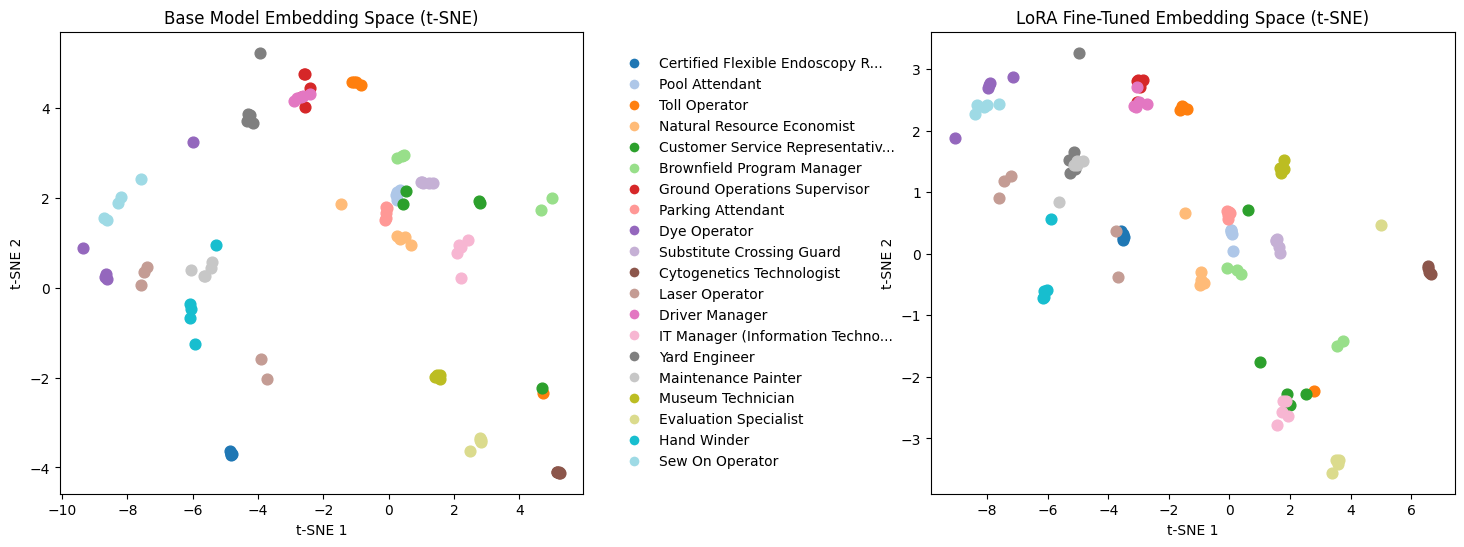

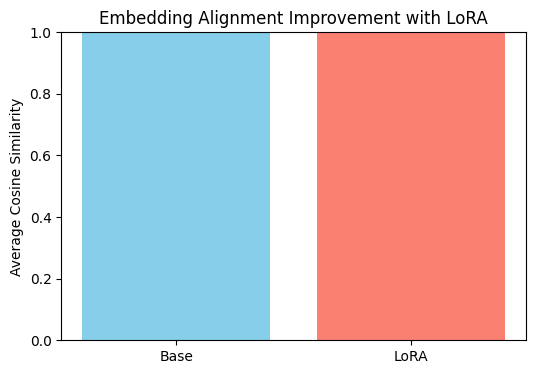

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# --- Compute Base Model Embeddings for comparison ---
base_model = SentenceTransformer(base_model_name, device=device)
base_embeddings = []
for i in trange(0, len(jittered_titles), 100):
    chunk = jittered_titles[i:i+100]
    base_embeddings.append(base_model.encode(chunk, normalize_embeddings=True, convert_to_numpy=True))
base_embeddings = np.concatenate(base_embeddings)

# --- t-SNE 2D projection ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
base_embeddings_2d = tsne.fit_transform(base_embeddings)
lora_embeddings_2d = tsne.fit_transform(embeddings)  # LoRA embeddings from your training

# --- Subset for clearer visualization ---
subset_size = 20
unique_titles = test_df['seed_title'].unique()
subset_titles = np.random.choice(unique_titles, subset_size, replace=False)
mask = test_df['seed_title'].isin(subset_titles)

base_subset_2d = base_embeddings_2d[mask, :]
lora_subset_2d = lora_embeddings_2d[mask, :]
test_df_subset = test_df[mask]

# --- Colors ---
colors = plt.cm.get_cmap('tab20', subset_size)
color_map = {title: colors(i) for i, title in enumerate(subset_titles)}
short_labels = {title: (title if len(title) <= 30 else title[:30] + '...') for title in subset_titles}

# --- Plot Base vs LoRA t-SNE ---
fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,3, width_ratios=[1,0.35,1], wspace=0.2)

ax_left = fig.add_subplot(gs[0])
ax_right = fig.add_subplot(gs[2])
ax_legend = fig.add_subplot(gs[1])

for title in subset_titles:
    idx = test_df_subset['seed_title'] == title
    ax_left.scatter(base_subset_2d[idx,0], base_subset_2d[idx,1], color=color_map[title], s=60)
    ax_right.scatter(lora_subset_2d[idx,0], lora_subset_2d[idx,1], color=color_map[title], s=60)

ax_left.set_title("Base Model Embedding Space (t-SNE)")
ax_left.set_xlabel("t-SNE 1"); ax_left.set_ylabel("t-SNE 2")
ax_right.set_title("LoRA Fine-Tuned Embedding Space (t-SNE)")
ax_right.set_xlabel("t-SNE 1"); ax_right.set_ylabel("t-SNE 2")

# Legend
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[t], markersize=8, label=short_labels[t])
           for t in subset_titles]
ax_legend.axis('off')
ax_legend.legend(handles=handles, loc='center', frameon=False, ncol=1)
plt.tight_layout()
plt.show()

# --- Optional: Average Cosine Similarity Comparison ---
cos_sim_base = [cosine_similarity([base_embeddings[i]], [base_embeddings[i]])[0,0] for i in range(len(base_embeddings))]
cos_sim_lora = [cosine_similarity([embeddings[i]], [embeddings[i]])[0,0] for i in range(len(embeddings))]

plt.figure(figsize=(6,4))
plt.bar(['Base', 'LoRA'], [np.mean(cos_sim_base), np.mean(cos_sim_lora)], color=['skyblue','salmon'])
plt.ylabel("Average Cosine Similarity")
plt.title("Embedding Alignment Improvement with LoRA")
plt.ylim(0,1)
plt.show()
